<a href="https://colab.research.google.com/github/ShaominXu/Image-and-video-processing-labs/blob/main/CNN%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA04

Name: Shaomin Xu

NetID: sx2311

## Defining the Dataset

### Download and extract the data

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2023-11-17 05:01:19--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  57.8MB/s    in 0.9s    

2023-11-17 05:01:20 (57.8 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-11-17 05:01:20--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-11-17 05:01:20--
Total wall clock time: 1.1s
Downloaded: 1 files, 51M in 0.9s (57.8 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

### Define a custom function for dataset reading

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        masks = torch.sum(masks, dim=0)
        masks = masks.unsqueeze(0)
        masks = torch.where(masks >= 1, torch.tensor(1.0), torch.tensor(0.0))


        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            # img, target = self.transforms(img, target)
            img, mask = self.transforms(img, target["masks"])


        return img, mask

    def __len__(self):
        return len(self.imgs)

### Define the augmentation transformations



In [ ]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
            transforms.append(T.RandomHorizontalFlip()),
            transforms.append(T.RandomVerticalFlip()),
            transforms.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)),
            # transforms.RandomResizedCrop((128, 128)),
    transforms.append(T.Resize((128, 128))),
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Set hyperparameters
batch_size = 8

# Load the dataset and split into train, val, and test sets
dataset_train = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset = PennFudanDataset('PennFudanPed', get_transform(train=False))
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset = torch.utils.data.Subset(dataset_train, indices[:train_size])
val_dataset = torch.utils.data.Subset(dataset, indices[train_size:train_size+val_size])
test_dataset = torch.utils.data.Subset(dataset, indices[train_size+val_size:])

# Print the number of samples in each split
print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in val set: {len(val_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of samples in train set: 136
Number of samples in val set: 17
Number of samples in test set: 17


### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


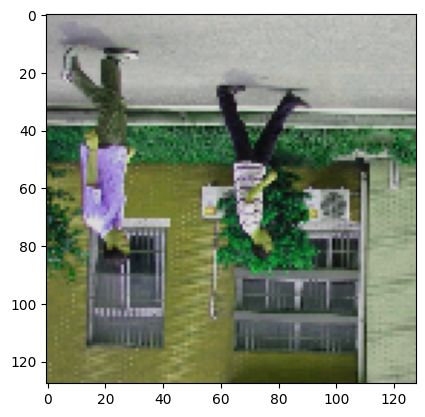

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Load the dataset
#dataset = ImageFolder('PennFudanPed/', transform=transformations)

# Show an example of the data augmentation
import matplotlib.pyplot as plt

# Get an example image and its corresponding label
img, mask = dataset_train[0]
pil_img = transforms.ToPILImage()(img)

# Display the PIL image
plt.imshow(pil_img)
plt.show()

## Defining the Model

### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture2, loss function, and any training hyper-parameters. You may implement any architecture you'd like, but the implementation must be your own code.

The U-Net architecture consists of an encoder that captures context information from the input image, and a decoder that upsamples the encoded features to generate the final output mask. The encoder has convolutional and pooling layers to reduce the spatial dimensions of the input image, and the decoder has convolutional and transpose convolutional layers to upsample the encoded features and generate the final output.

The loss function used here is Soft-Dice Loss.

The optimizer we used here is adam. The hyperparameters chose are: learning_rate= 0.001, batch_size=8, epoch=40.

### Define the U-Net Architecture

I implement the proposed UNet architecture.

In [ ]:
import torch
import torch.nn as nn

# Define UNet architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Define encoder layers
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        # Bottom layer
        self.bottom_layer = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        # Define decoder layers
        self.decoder_layer1 = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        self.decoder_layer2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Sigmoid activation for binary segmentation
        )

        # Max-pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        e1 = self.encoder_layer1(x)
        x = self.pool(e1)
        e2 = self.encoder_layer2(x)
        x = self.pool(e2)
        # Bottom
        x = self.bottom_layer(x)
        # Decoder
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((e2, x), dim=1)
        x = self.decoder_layer1(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((e1, x), dim=1)
        x = self.decoder_layer2(x)
        return x

In [ ]:
from torch.optim import lr_scheduler
import tensorflow as tf

# Set hyperparameters
num_epochs = 40
batch_size = batch_size
learning_rate = 0.001

# Define Dice coefficient function
def dice_score(set_a, set_b):
    intersection = torch.sum(set_a.int() & set_b.int())
    dice = 2 * intersection / (torch.sum(set_a) + torch.sum(set_b))
    return dice

# Define the Soft Dice Loss
class SoftDiceLoss(nn.Module):
    def __init__(self, epsilon=1):
        super(SoftDiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, logits, targets):
        intersection = torch.sum(logits * targets)
        union = torch.sum(logits) + torch.sum(targets) + self.epsilon
        dice_loss = 1 - ((2.0 * intersection + self.epsilon) / union)
        return dice_loss


# Initialize the UNet model, loss function, and optimizer
model = UNet()
criterion = SoftDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNet(
  (encoder_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (bottom_layer): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, 

## Training the Model

In [ ]:
# # This reports training loss, validation loss, and validation DICE curves
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.utils as vutils
#import torchvision.transforms.functional as F
import matplotlib.pyplot as plt


# Initialize lists to store training/validation loss and validation Dice coefficient
# Initialize lists to store training/validation loss and validation Dice coefficient
train_loss_list = []
val_loss_list = []
val_dice_list = []
test_dice_list = []  # Initialize list to store test Dice coefficients
best_val_loss = float('inf')

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0  # Initialize training loss for current epoch
    model.train()  # Set the model to training mode

    for images, masks in train_dataloader:

        # Move data to GPU if available
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate Soft Dice Loss
        lossT = criterion(outputs, masks)

        # Backward pass
        lossT.backward()

        # Update weights
        optimizer.step()

        # Accumulate training loss
        train_loss += lossT.item()

    # Calculate average training loss for current epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_list.append(avg_train_loss)

    # Calculate validation loss and Dice coefficient for current epoch
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        val_losses = 0
        val_dices = 0
        for images, masks in val_dataloader:
            # Resize masks to match input image size (128x128)
            # resized_masks = F.resize(masks, (128, 128))

            # Move data to GPU if available
            images = images.to(device)
            masks = masks.to(device)
            # resized_masks = resized_masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate validation loss
            lossV = criterion(outputs, masks)
            val_losses += lossV.item()

            # Calculate Dice coefficient
            # outputs = torch.sigmoid(outputs)
            outputs = torch.where(outputs > 0.5, torch.tensor(1), torch.tensor(0)) # Convert to binary predictions
            dice = dice_score(outputs, masks)
            val_dices += dice.item()

        # Calculate average validation loss and Dice coefficient
        avg_val_loss = val_losses / len(val_dataloader)
        avg_val_dice = val_dices / len(val_dataloader)
        val_loss_list.append(avg_val_loss)
        val_dice_list.append(avg_val_dice)

    # Adjust learning rate
    scheduler.step()

    # Save the best performing model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_checkpoint.pth")


    # Print validation results
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/40], Train Loss: 0.6806, Val Loss: 0.7879, Val Dice: 0.0000
Epoch [2/40], Train Loss: 0.5851, Val Loss: 0.6110, Val Dice: 0.5267
Epoch [3/40], Train Loss: 0.5239, Val Loss: 0.5568, Val Dice: 0.4915
Epoch [4/40], Train Loss: 0.4782, Val Loss: 0.5327, Val Dice: 0.5026
Epoch [5/40], Train Loss: 0.4332, Val Loss: 0.4322, Val Dice: 0.6286
Epoch [6/40], Train Loss: 0.4109, Val Loss: 0.4268, Val Dice: 0.6178
Epoch [7/40], Train Loss: 0.3870, Val Loss: 0.3908, Val Dice: 0.6405
Epoch [8/40], Train Loss: 0.3699, Val Loss: 0.4866, Val Dice: 0.5224
Epoch [9/40], Train Loss: 0.3655, Val Loss: 0.3884, Val Dice: 0.6296
Epoch [10/40], Train Loss: 0.3647, Val Loss: 0.4425, Val Dice: 0.5660
Epoch [11/40], Train Loss: 0.3419, Val Loss: 0.3542, Val Dice: 0.6569
Epoch [12/40], Train Loss: 0.3228, Val Loss: 0.3091, Val Dice: 0.7087
Epoch [13/40], Train Loss: 0.3084, Val Loss: 0.3095, Val Dice: 0.7075
Epoch [14/40], Train Loss: 0.3017, Val Loss: 0.3212, Val Dice: 0.6947
Epoch [15/40], Train Loss: 0.

### (d) Report training loss, validation loss, and validation DICE curves. Comment on any over fitting or under fitting observed.

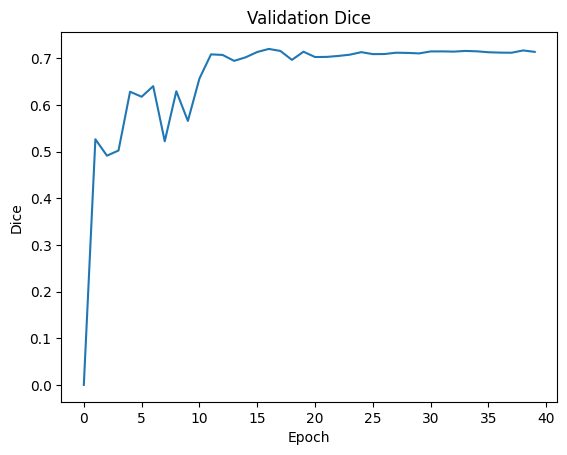

In [ ]:
# Plot validation Dice curve
plt.plot(val_dice_list)
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Validation Dice')
plt.show()

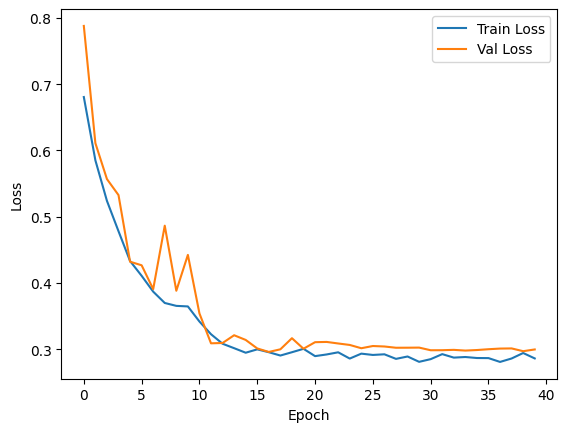

In [ ]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (e) Report the average dice score over your test-set.
You should be able to achieve a score of around 0.7 or better.

In [ ]:
# Load the model checkpoint
checkpoint_path = 'best_model_checkpoint.pth'
checkpoint = torch.load(checkpoint_path)

# Load the model state dictionary
model.load_state_dict(checkpoint)

# Put the model in evaluation mode
model.eval()

with torch.no_grad():
        test_losses = 0
        test_dices = 0
        for images, masks in val_dataloader:
            # Resize masks to match input image size (128x128)
            # resized_masks = F.resize(masks, (128, 128))

            # Move data to GPU if available
            images = images.to(device)
            masks = masks.to(device)
            # resized_masks = resized_masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate validation loss
            loss = criterion(outputs, masks)
            test_losses += loss.item()

            # Calculate Dice coefficient
            # outputs = torch.sigmoid(outputs)
            outputs = torch.where(outputs > 0.5, torch.tensor(1), torch.tensor(0)) # Convert to binary predictions
            dice = dice_score(outputs, masks)
            test_dices += dice.item()

        # Calculate average validation loss and Dice coefficient
        avg_test_loss = test_losses / len(test_dataloader)
        avg_test_dice = test_dices / len(test_dataloader)

print(f"Avarage test loss: {avg_test_loss:.2f}")
print(f"Avarage test dice score: {avg_test_dice:2f}")

Avarage test loss: 0.30
Avarage test dice score: 0.720363


### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image × mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


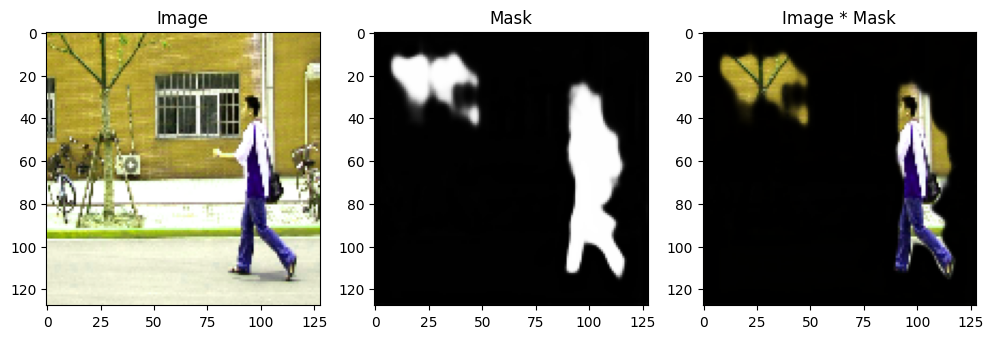

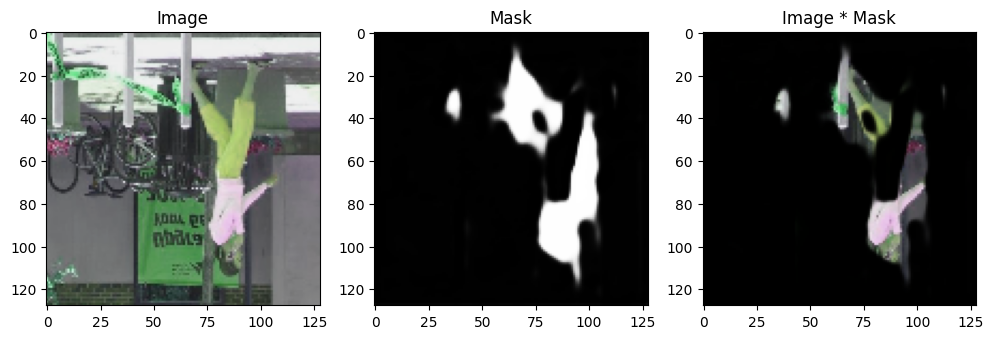

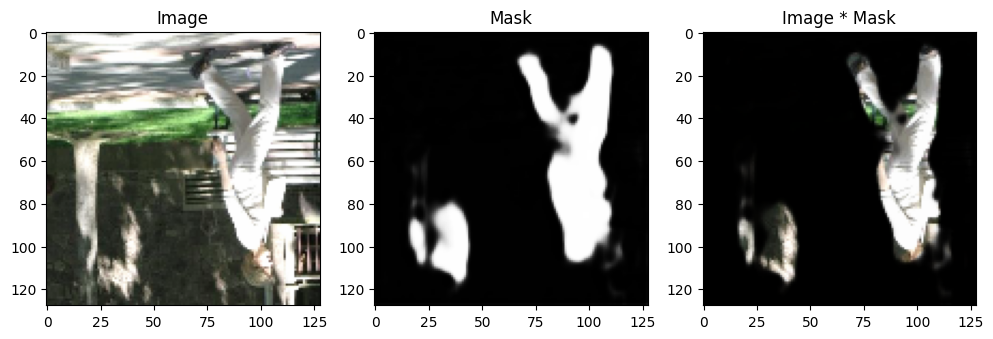

In [ ]:
# 3 example segmentations fromm training data
from PIL import Image
for batch_idx, (images, masks) in enumerate(train_dataloader):
  if batch_idx == 0:
    imgs = images[:3]
    imgs = imgs.to(device)
    masks = model(imgs)
    for i in range(3):
      pil_img = transforms.ToPILImage()(imgs[i])
      pil_mask = transforms.ToPILImage()(masks[i])
      pil_img_mask = transforms.ToPILImage()(imgs[i]*masks[i])

      # Display the images and masks
      plt.figure(figsize=(12, 4))

      plt.subplot(1, 3, 1)
      plt.imshow(pil_img)
      plt.title('Image')

      plt.subplot(1, 3, 2)
      plt.imshow(pil_mask, cmap='gray')
      plt.title('Mask')

      plt.subplot(1, 3, 3)
      plt.imshow(pil_img_mask)
      plt.title('Image * Mask')

      plt.show()

  break


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


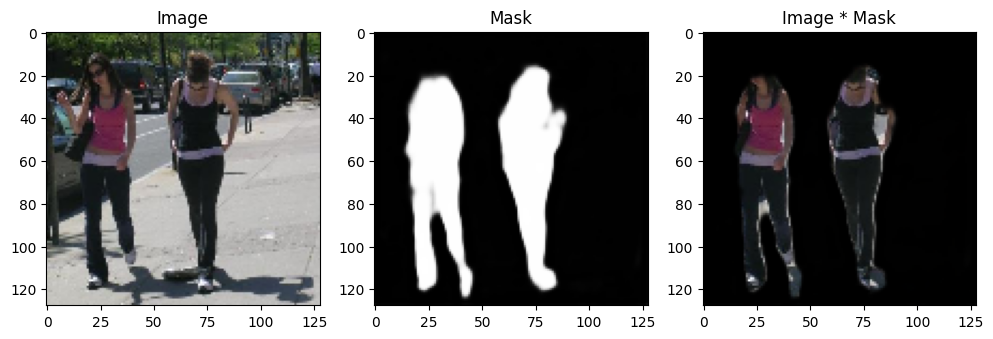

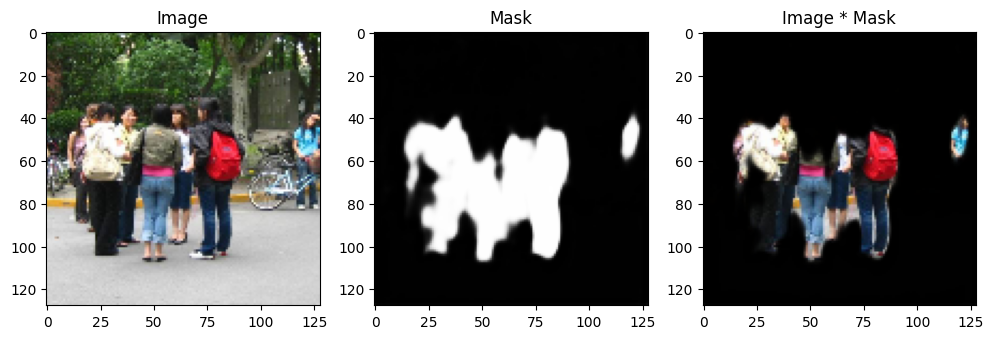

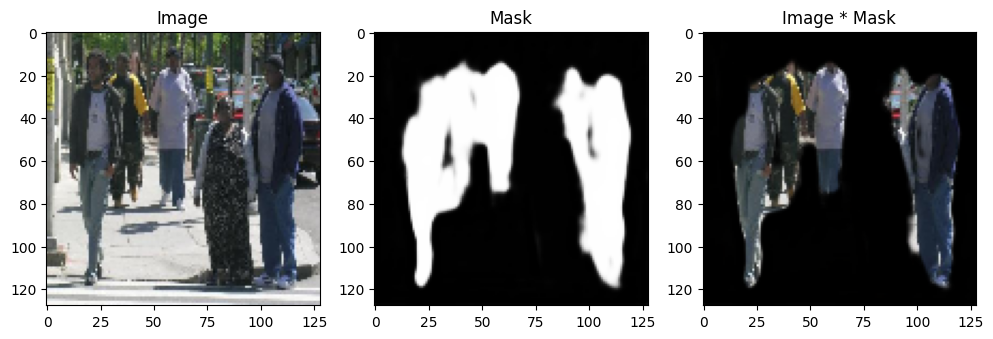

In [ ]:
# 3 example segmentations fromm test data
from PIL import Image
for batch_idx, (images, masks) in enumerate(test_dataloader):
  if batch_idx == 0:
    imgs = images[:3]
    imgs = imgs.to(device)
    masks = model(imgs)
    for i in range(3):
      pil_img = transforms.ToPILImage()(imgs[i])
      pil_mask = transforms.ToPILImage()(masks[i])
      pil_img_mask = transforms.ToPILImage()(imgs[i]*masks[i])

      # Display the images and masks
      plt.figure(figsize=(12, 4))

      plt.subplot(1, 3, 1)
      plt.imshow(pil_img)
      plt.title('Image')

      plt.subplot(1, 3, 2)
      plt.imshow(pil_mask, cmap='gray')
      plt.title('Mask')

      plt.subplot(1, 3, 3)
      plt.imshow(pil_img_mask)
      plt.title('Image * Mask')

      plt.show()

  break


The generalization capabilities of the trained network is not good enough.

### (g) Show at least 1 example segmentation on an input image not from the FudanPed dataset. Again, comment on the generalization capabilities of your network with respect to this “out-of-distribution” image.

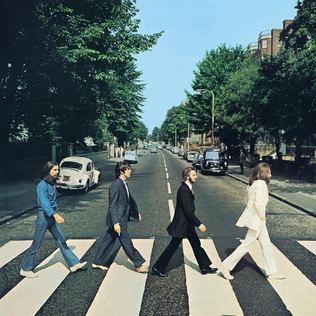

In [ ]:
import requests
from PIL import Image

url = "https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg"
response = requests.get(url)
with open("Beatles_-_Abbey_Road.jpg", "wb") as f:
    f.write(response.content)

Image.open("Beatles_-_Abbey_Road.jpg")


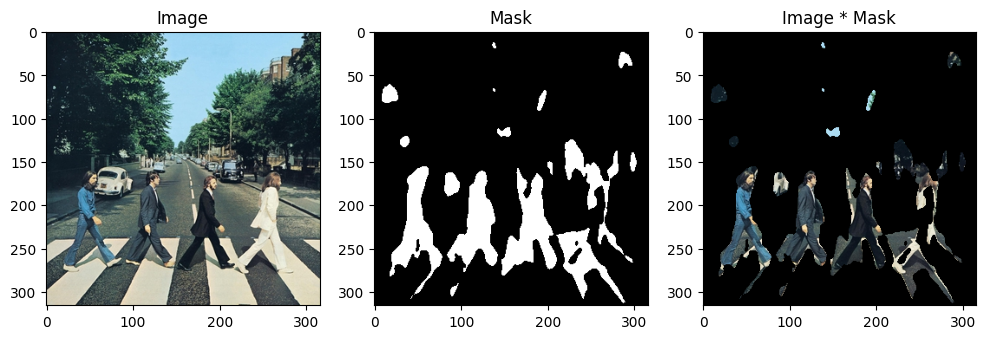

In [ ]:
img_rgb = Image.open("Beatles_-_Abbey_Road.jpg").convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
img = transform(img_rgb).unsqueeze(0)
img = img.to(device)

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    mask = model(img)
mask = torch.where(mask > 0.5, torch.tensor(1), torch.tensor(0)) # Convert to binary predictions

img = img.squeeze(0)
mask = mask.squeeze(0).to(dtype=torch.uint8)
pil_img = transforms.ToPILImage()(img)
pil_mask = transforms.ToPILImage()(mask)
pil_img_mask = transforms.ToPILImage()(img*mask)
# Display the images and masks
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(pil_img)
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(pil_mask, cmap='gray')
plt.title('Mask')

plt.subplot(1, 3, 3)
plt.imshow(pil_img_mask)
plt.title('Image * Mask')

plt.show()

The generalization capabilities of the trained network is not good enough.